# Bandit Algorithms

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
class BanditAlgorithm:

    def __init__(self, algorithm, reward_dists):
        self.arm_value_estimates = {arm: 0 for arm in reward_dists}
        self.arm_counts = {arm: 0 for arm in reward_dists}
        self.reward_dists = reward_dists
        self.algorithm = algorithm

    def __call__(self, n_steps):
        actions = []
        rewards = []
        for step in range(n_steps):

            # policy - choose arm to pull and get reward
            action, reward = self.algorithm(self.arm_value_estimates, self.arm_counts, self.reward_dists)

            # perform updates    
            self.arm_value_estimates[action] = (self.arm_counts[action] * self.arm_value_estimates[action] + reward) / (self.arm_counts[action] + 1)
            self.arm_counts[action] += 1

            # track actions and rewards
            actions.append(action)
            rewards.append(reward)

        return actions, rewards

    def reset(self):
        self.arm_value_estimates = {arm: 0 for arm in self.reward_dists}
        self.arm_counts = {arm: 0 for arm in self.reward_dists}

Have implemented:
- Greedy
- Epsilon greedy
- Policy gradient
- UCB

In [69]:
class Greedy:

    def __call__(self, arm_value_estimates, arm_counts, reward_dists):
        action_idx = np.array(list(arm_value_estimates.values())).argmax()
        action = list(arm_value_estimates.keys())[action_idx]
        reward = reward_dists[action]()
        return action, reward
    

class EpsilonGreedy:

    def __init__(self, eps):
        self.eps = eps

    def __call__(self, arm_value_estimates, arm_counts, reward_dists):
        if np.random.rand() < self.eps:
            action = list(arm_value_estimates.keys())[np.random.randint(0, len(arm_value_estimates.keys()))]
        else:
            action_idx = np.array(list(arm_value_estimates.values())).argmax()
            action = list(arm_value_estimates.keys())[action_idx]
        reward = reward_dists[action]()
        return action, reward
    
class PolicyGradient:

    def __init__(self, alpha, n_arms):
        self.alpha = alpha
        self.preferences = np.ones(shape=(n_arms,))
        self.probs = np.exp(self.preferences) / np.exp(self.preferences).sum()

    def __call__(self, arm_value_estimates, arm_counts, reward_dists):
        action_idx = np.random.multinomial(1, self.probs).argmax()
        action = list(arm_value_estimates.keys())[action_idx]
        reward = reward_dists[action]()

        update = -1 * self.alpha * reward * self.probs
        update[action_idx] = self.alpha * reward * (1 - self.probs[action_idx])
        self.preferences += update
        self.probs = np.exp(self.preferences) / np.exp(self.preferences).sum()

        return action, reward
    
class UCB:

    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, arm_value_estimates, arm_counts, reward_dists):
        t = np.sum(arm_counts.values())
        ns = np.array(list(arm_counts.values()))
        ns = np.where(ns == 0, 0.01, ns)
        us = (1 / (2 * ns))
        upper_bounds = np.array(list(arm_value_estimates.values())) + self.alpha * us ** 0.5
        action_idx = upper_bounds.argmax()
        action = list(arm_value_estimates.keys())[action_idx]
        reward = reward_dists[action]()
        return action, reward


In [16]:
gen = np.random.default_rng()
basic_bandit = {i: (lambda i=i: gen.normal(loc=i, scale=1)) for i in range(-5,6)}

In [73]:
n_arms = len(basic_bandit.keys())
greedy_alg = BanditAlgorithm(Greedy(), basic_bandit)
eps_greedy_alg = BanditAlgorithm(EpsilonGreedy(0.1), basic_bandit)
pg_alg = BanditAlgorithm(PolicyGradient(0.01, n_arms), basic_bandit)
ucb_alg = BanditAlgorithm(UCB(0.5), basic_bandit)

- Greedy algorithm

Text(0.5, 1.0, 'Rewards Achieved By Greedy Policy')

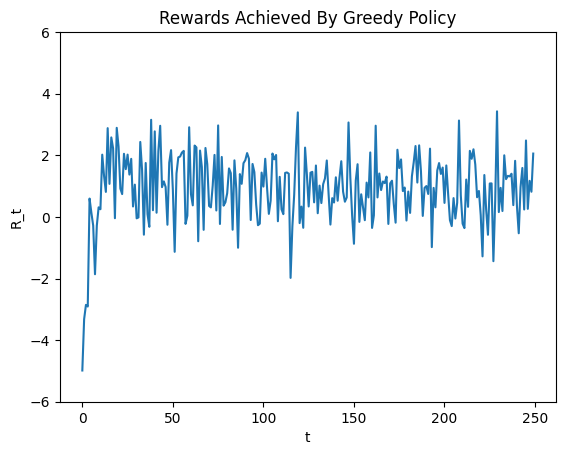

In [63]:
greedy_alg = BanditAlgorithm(Greedy(), basic_bandit)
actions, rewards = greedy_alg(250)
plt.plot(rewards)
plt.ylim(-6,6)
plt.ylabel("R_t")
plt.xlabel("t")
plt.title("Rewards Achieved By Greedy Policy")

- Epsilon greedy algorithm with different values of epsilon

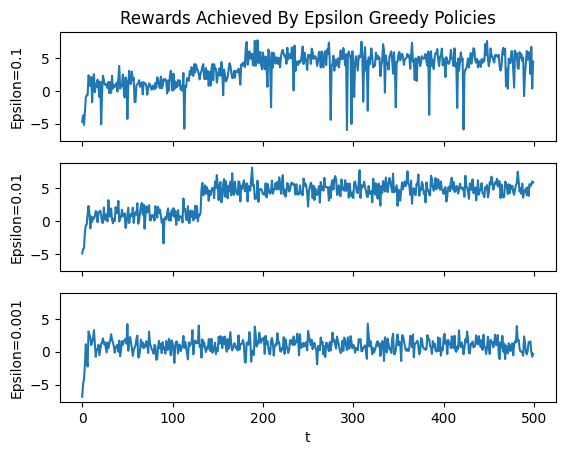

In [64]:
fig, axs = plt.subplots(3, sharey=True, sharex=True)
eps_greedy_alg = BanditAlgorithm(EpsilonGreedy(0.1), basic_bandit)
actions, rewards = eps_greedy_alg(500)
axs[0].plot(rewards, label="0.1")
axs[0].set_ylabel("Epsilon=0.1")
axs[0].set_title("Rewards Achieved By Epsilon Greedy Policies")
eps_greedy_alg = BanditAlgorithm(EpsilonGreedy(0.01), basic_bandit)
actions, rewards = eps_greedy_alg(500)
axs[1].plot(rewards, label="0.01")
axs[1].set_ylabel("Epsilon=0.01")
eps_greedy_alg = BanditAlgorithm(EpsilonGreedy(0.001), basic_bandit)
actions, rewards = eps_greedy_alg(500)
axs[2].plot(rewards, label="0.001")
axs[2].set_xlabel("t")
axs[2].set_ylabel("Epsilon=0.001")
plt.show()

- UCB Algorithm

Text(0.5, 1.0, 'Rewards Achieved By UCB')

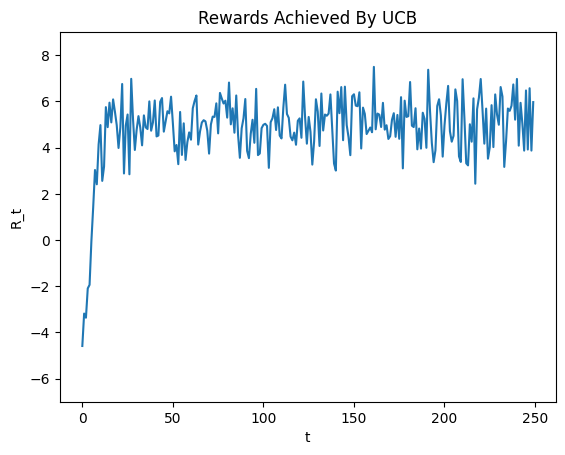

In [112]:
ucb_alg = BanditAlgorithm(UCB(2**0.5), basic_bandit)
actions, rewards = ucb_alg(250)
plt.plot(rewards)
plt.ylim(-7,9)
plt.ylabel("R_t")
plt.xlabel("t")
plt.title("Rewards Achieved By UCB")

In [84]:
def eval_algorithms(algorithms, n_runs, n_iters):
    avg_rewards = []
    for algorithm in algorithms:
        alg_rewards = np.zeros((n_runs, n_iters))
        for i in range(n_runs):
            algorithm.reset()
            actions, rewards = algorithm(n_iters)
            alg_rewards[i, :] = rewards
        avg_rewards.append(list(alg_rewards.mean(axis=0)))
    return avg_rewards

- Evaluate the performance of different action value estimate algorithms

In [115]:
greedy_alg = BanditAlgorithm(Greedy(), basic_bandit)
eps_greedy_alg_0001 = BanditAlgorithm(EpsilonGreedy(0.001), basic_bandit)
eps_greedy_alg_001 = BanditAlgorithm(EpsilonGreedy(0.01), basic_bandit)
eps_greedy_alg_01 = BanditAlgorithm(EpsilonGreedy(0.1), basic_bandit)
ucb_alg_r2 = BanditAlgorithm(UCB(2**0.5), basic_bandit)
ucb_alg_1 = BanditAlgorithm(UCB(1), basic_bandit)
ucb_alg_2 = BanditAlgorithm(UCB(2), basic_bandit)
rewards = eval_algorithms([greedy_alg, eps_greedy_alg_01, eps_greedy_alg_001, eps_greedy_alg_0001, ucb_alg_r2, ucb_alg_1, ucb_alg_2], 1000, 1000)

Text(0, 0.5, 'R_t')

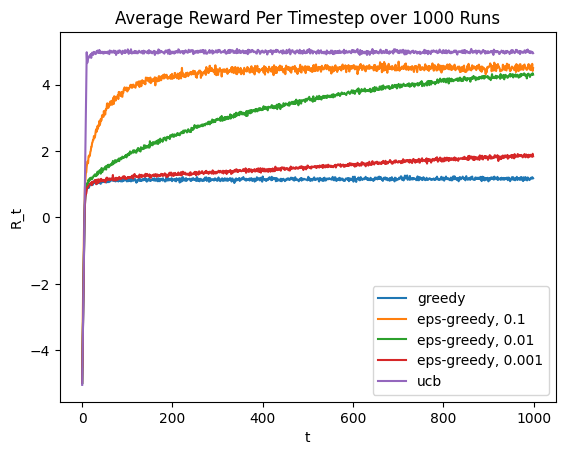

In [121]:
for reward, lab in zip(rewards, ["greedy", "eps-greedy, 0.1", "eps-greedy, 0.01", "eps-greedy, 0.001", "ucb"]):
    plt.plot(reward, label=lab)
plt.legend()
plt.title("Average Reward Per Timestep over 1000 Runs")
plt.xlabel("t")
plt.ylabel("R_t")

- Policy gradient algorithm

Text(0.5, 1.0, 'Rewards Achieved By UCB')

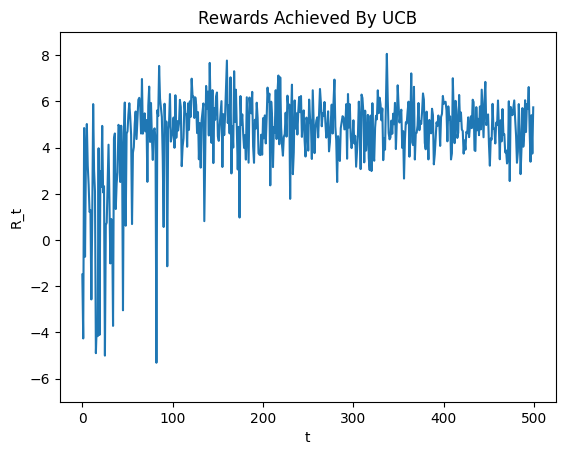

In [128]:
n_arms = len(basic_bandit.keys())
pg_alg = BanditAlgorithm(PolicyGradient(0.1, n_arms), basic_bandit)
actions, rewards = pg_alg(500)
plt.plot(rewards)
plt.ylim(-7,9)
plt.ylabel("R_t")
plt.xlabel("t")
plt.title("Rewards Achieved By UCB")

- Compare policy gradient with UCB and epsilon-greedy

Text(0, 0.5, 'R_t')

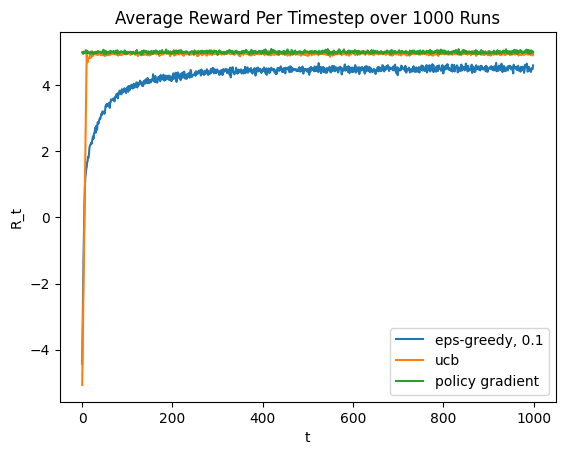

In [129]:
eps_greedy_alg_01 = BanditAlgorithm(EpsilonGreedy(0.1), basic_bandit)
ucb_alg_1 = BanditAlgorithm(UCB(1), basic_bandit)
pg_alg_01 = BanditAlgorithm(PolicyGradient(0.1, n_arms), basic_bandit)
rewards = eval_algorithms([eps_greedy_alg_01, ucb_alg_1, pg_alg_01], 1000, 1000)

for reward, lab in zip(rewards, ["eps-greedy, 0.1", "ucb", "policy gradient"]):
    plt.plot(reward, label=lab)
plt.legend()
plt.title("Average Reward Per Timestep over 1000 Runs")
plt.xlabel("t")
plt.ylabel("R_t")